## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve                        
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

np.random.seed(0)
plt.rcParams['figure.figsize'] = (12, 10)
pd.set_option('display.max_columns', None)

## Importing written algorithm

In [2]:
import sys
sys.path.append("C:\\Users\\rafael_s\\PycharmProjects\\pythonProject")
from symprod import SyMProD

# 1. Algorithm explanation
#### Algorithm based by this __[paper](https://sci-hub.do/10.1109/ACCESS.2020.3003346)__

In [3]:
model = SyMProD(nt=3.5, ct=0.8, k=5, m=3)
help(model)

Help on SyMProD in module symprod object:

class SyMProD(builtins.object)
 |  SyMProD(nt: float, ct: float, k: int, m: int) -> None
 |  
 |  This class is called Synthetic Minority Probabilistic Distribution Oversampling technique,
 |  whole class and its methods are based by this article https://sci-hub.do/10.1109/ACCESS.2020.3003346,
 |  Algorithm is divided by below steps.
 |  
 |  Step1: Find number of instances that has to be generated for balancing data
 |  
 |  Step2: Get out of outliers in minority instances by given noise threshold with Z_score method, and find k the
 |  nearest minority and majority neighbors for each minority instance
 |  
 |  Step3: Get out from overlapping instances by given cutoff threshold
 |  
 |  Step4: Find the m nearest minority instances for each remained minority instance
 |  
 |  Step5: Generate new instances with Probabilistic method
 |  
 |  Methods defined here:
 |  
 |  __init__(self, nt: float, ct: float, k: int, m: int) -> None
 |      :para

# 2. Describtion of Data

## 2.1 Describtion(Info)

In [4]:
data = pd.read_csv("C:/Users/rafael_s/Downloads/telecom_churn.csv")
print("DataFrame shape", data.shape, sep='\n')
print()
print("First 10 rows of DataFrame")
data.head(10)

DataFrame shape
(3333, 11)

First 10 rows of DataFrame


Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0      0           128                1         1       2.70              1   
1      0           107                1         1       3.70              1   
2      0           137                1         0       0.00              0   
3      0            84                0         0       0.00              2   
4      0            75                0         0       0.00              3   
5      0           118                0         0       0.00              0   
6      0           121                1         1       2.03              3   
7      0           147                0         0       0.00              0   
8      0           117                1         0       0.19              1   
9      0           141                0         1       3.02              0   

   DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0    265.1       110           89.0        9.87      10.0  
1    161.6       123           82.0        9.78      13.7  
2    243.4       114           52.0        6.06      12.2  
3    299.4        71           57.0        3.10       6.6  
4    166.7       113           41.0        7.42      10.1  
5    223.4        98           57.0       11.03       6.3  
6    218.2        88           87.3       17.43       7.5  
7    157.0        79           36.0        5.16       7.1  
8    184.5        97           63.9       17.58       8.7  
9    258.6        84           93.2       11.10      11.2

**Data Description**

- Churn - 1 if customer cancelled service, 0 if not
- AccountWeeks - number of weeks customer has had active account
- ContractRenewal - 1 if customer recently renewed contract, 0 if not
- DataPlan - 1 if customer has data plan, 0 if not
- DataUsage - gigabytes of monthly data usage
- CustServCalls - number of calls into customer service
- DayMins - average daytime minutes per month
- DayCalls - average number of daytime calls
- MonthlyCharge - average monthly bill
- OverageFee - largest overage fee in last 12 months
- RoamMins - average number of roaming minutes

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [6]:
data.describe().round(decimals=0)

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  \
count  3333.0        3333.0           3333.0    3333.0     3333.0   
mean      0.0         101.0              1.0       0.0        1.0   
std       0.0          40.0              0.0       0.0        1.0   
min       0.0           1.0              0.0       0.0        0.0   
25%       0.0          74.0              1.0       0.0        0.0   
50%       0.0         101.0              1.0       0.0        0.0   
75%       0.0         127.0              1.0       1.0        2.0   
max       1.0         243.0              1.0       1.0        5.0   

       CustServCalls  DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
count         3333.0   3333.0    3333.0         3333.0      3333.0    3333.0  
mean             2.0    180.0     100.0           56.0        10.0      10.0  
std              1.0     54.0      20.0           16.0         3.0       3.0  
min              0.0      0.0       0.0           14.0         0.0       0.0  
25%              1.0    144.0      87.0           45.0         8.0       8.0  
50%              1.0    179.0     101.0           54.0        10.0      10.0  
75%              2.0    216.0     114.0           66.0        12.0      12.0  
max              9.0    351.0     165.0          111.0        18.0      20.0

In [7]:
data.nunique()

Churn                 2
AccountWeeks        212
ContractRenewal       2
DataPlan              2
DataUsage           174
CustServCalls        10
DayMins            1667
DayCalls            119
MonthlyCharge       627
OverageFee         1024
RoamMins            162
dtype: int64

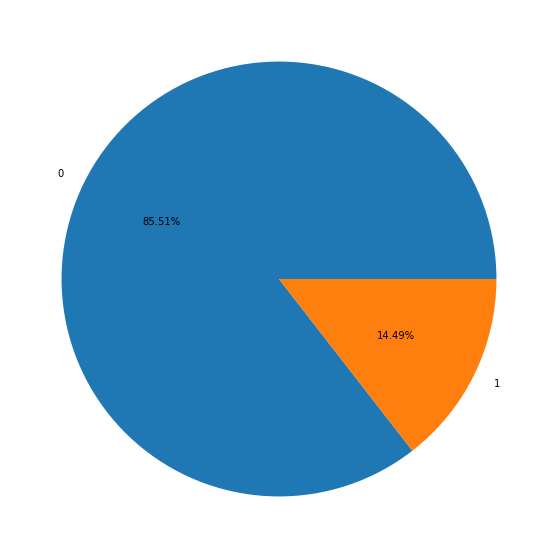

In [8]:
labels, counts = np.unique(data.Churn.values, return_counts=True)
plt.pie(x=counts, labels=labels, autopct="%1.2f%%");

## 2.2 EDA 

In [9]:
data.groupby('Churn').mean()

AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
Churn                                                                      
0        100.793684         0.934737  0.295439   0.862151       1.449825   
1        102.664596         0.716356  0.165631   0.546957       2.229814   

          DayMins    DayCalls  MonthlyCharge  OverageFee   RoamMins  
Churn                                                                
0      175.175754  100.283158      55.816246    9.954618  10.158877  
1      206.914079  101.335404      59.190062   10.623085  10.700000

As we can see the clients that churn used less DataPlan and DataUsage and called to call center more often. With other features they are similar.

Describition of ContractRenewal
count    3333.000000
mean        0.903090
std         0.295879
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: ContractRenewal, dtype: float64


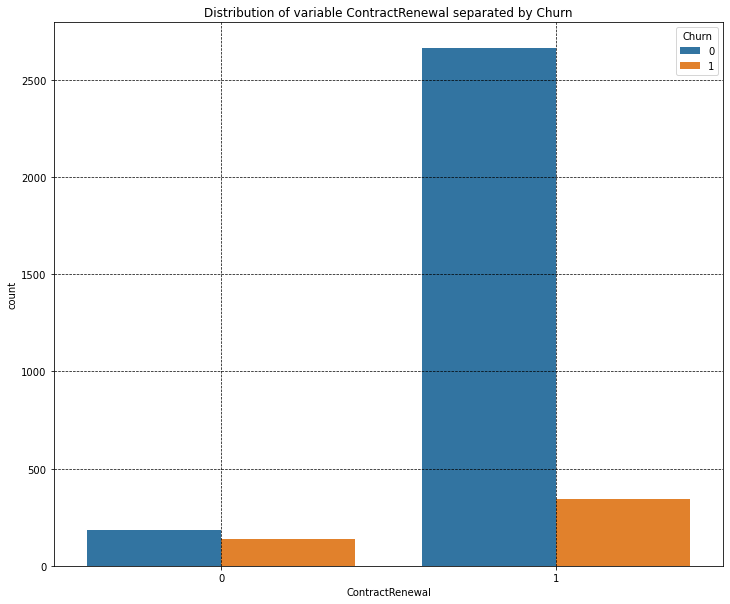

In [10]:
print("Describition of ContractRenewal", data['ContractRenewal'].describe(), sep='\n')
sns.countplot(data = data, x='ContractRenewal', hue = 'Churn');
plt.title('Distribution of variable ContractRenewal separated by Churn')
plt.grid (color = 'black', linestyle = '--', linewidth = 0.7)

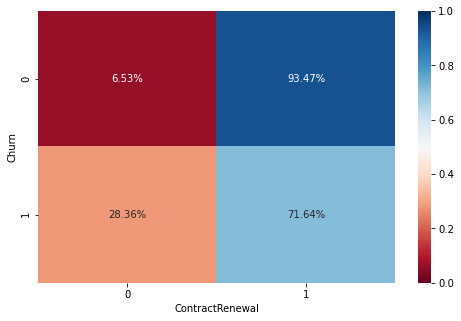

In [10]:
cross = pd.crosstab(data['Churn'], data['ContractRenewal']
                    ).apply(lambda r: r/r.sum(), axis=1)

plt.figure(figsize=(8, 5))
s = sns.heatmap(cross, annot=True, fmt='.2%',cmap='RdBu', vmin=0, vmax=1)

Describition of DataPlan
count    3333.000000
mean        0.276628
std         0.447398
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: DataPlan, dtype: float64


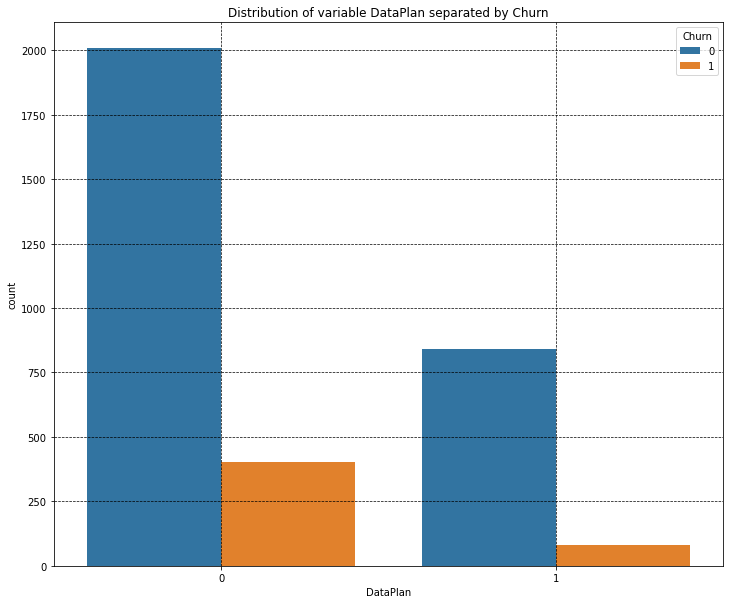

In [11]:
print("Describition of DataPlan", data['DataPlan'].describe(), sep='\n')
sns.countplot(data = data, x="DataPlan", hue = 'Churn');
plt.title('Distribution of variable DataPlan separated by Churn')
plt.grid (color = 'black', linestyle = '--', linewidth = 0.7)

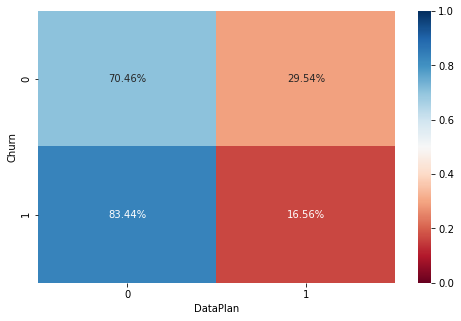

In [12]:
cross = pd.crosstab(data['Churn'], data['DataPlan']
                    ).apply(lambda r: r/r.sum(), axis=1)

plt.figure(figsize=(8, 5))
s = sns.heatmap(cross, annot=True, fmt='.2%', cmap='RdBu', vmin=0, vmax=1)

Describition of CustServCalls
count    3333.000000
mean        1.562856
std         1.315491
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: CustServCalls, dtype: float64


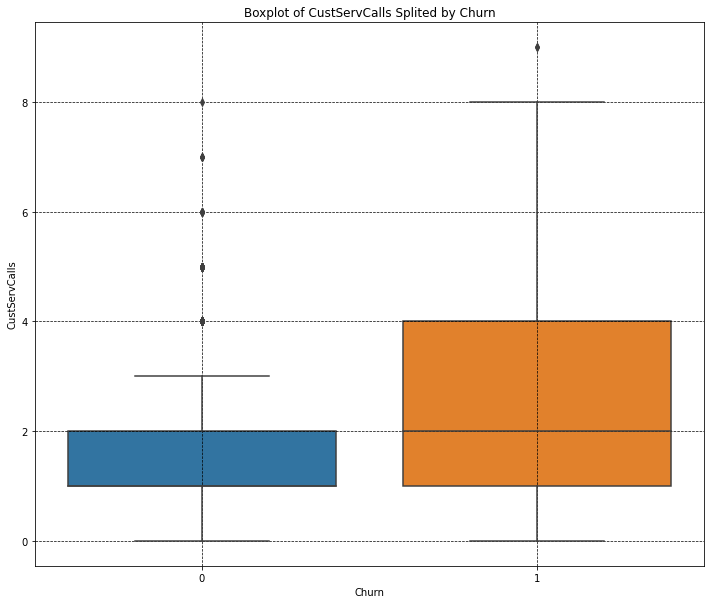

In [13]:
print("Describition of CustServCalls", data['CustServCalls'].describe(), sep='\n')
plt.title("Boxplot of CustServCalls Splited by Churn")
sns.boxplot(data = data, x = 'Churn', y = 'CustServCalls');
plt.grid (color = 'black', linestyle = '--', linewidth = 0.7)

Describition of DayMins
count    3333.000000
mean      179.775098
std        54.467389
min         0.000000
25%       143.700000
50%       179.400000
75%       216.400000
max       350.800000
Name: DayMins, dtype: float64


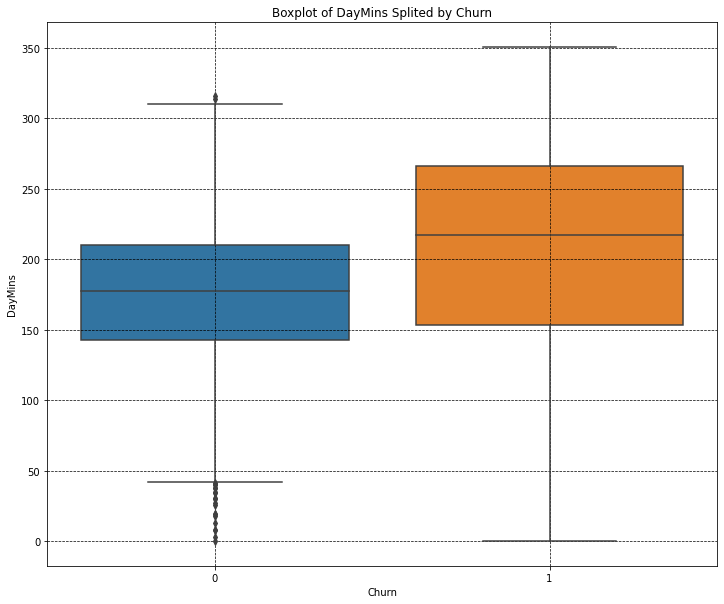

In [14]:
print("Describition of DayMins", data['DayMins'].describe(), sep='\n')
plt.title("Boxplot of DayMins Splited by Churn")
sns.boxplot(data = data, x = 'Churn', y = 'DayMins');
plt.grid (color = 'black', linestyle = '--', linewidth = 0.7)

From the graph above we can see that customers that churn call more often to customer services center, but this difference is not to big.

Describition of RoamMins
count    3333.000000
mean       10.237294
std         2.791840
min         0.000000
25%         8.500000
50%        10.300000
75%        12.100000
max        20.000000
Name: RoamMins, dtype: float64


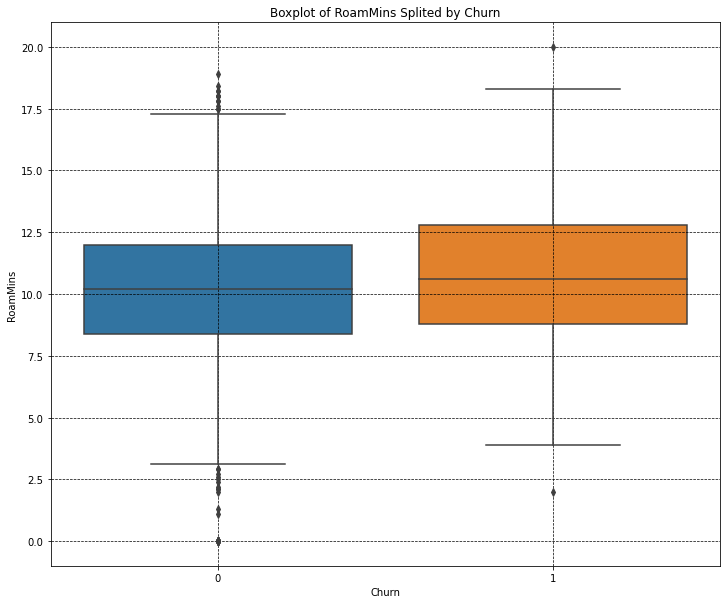

In [15]:
print("Describition of RoamMins", data['RoamMins'].describe(), sep='\n')
plt.title("Boxplot of RoamMins Splited by Churn")
sns.boxplot(data = data, x = 'Churn', y = 'RoamMins');
plt.grid (color = 'black', linestyle = '--', linewidth = 0.7)

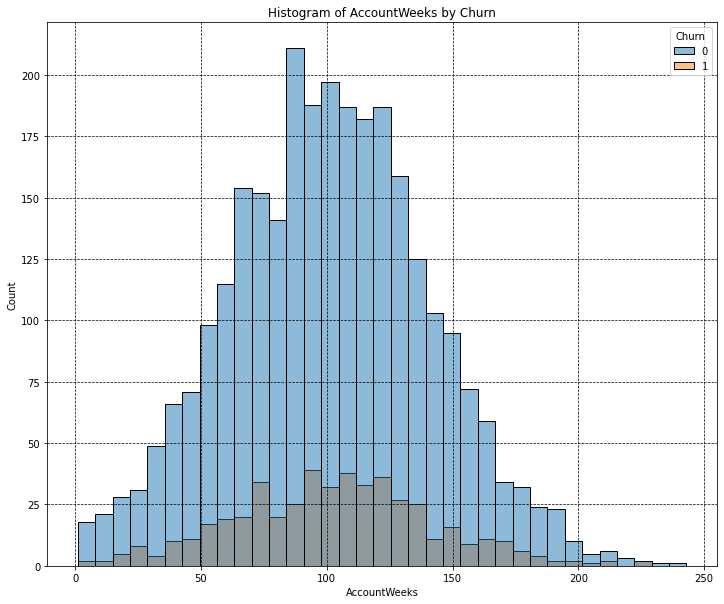

In [16]:
plt.title("Histogram of AccountWeeks by Churn")
sns.histplot(data = data, x = "AccountWeeks", hue = "Churn");
plt.grid (color = 'black', linestyle = '--', linewidth = 0.7)

From the graph above we can conclude that customers that churn and don't churn have similar distribution and differ only on ters of count.

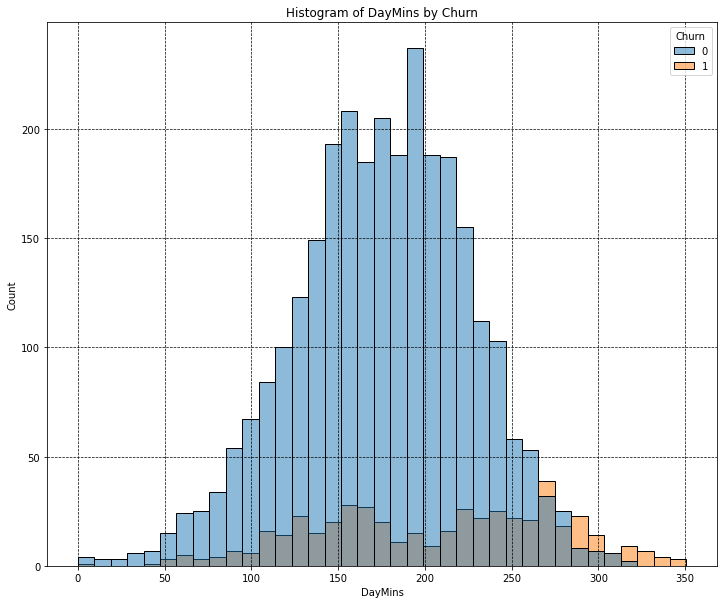

In [17]:
plt.title("Histogram of DayMins by Churn")
sns.histplot(data = data, x = "DayMins", hue = "Churn");
plt.grid (color = 'black', linestyle = '--', linewidth = 0.7)

From the graph above we can conclude that chustomers that churn made moore cals than customers that don't churn.

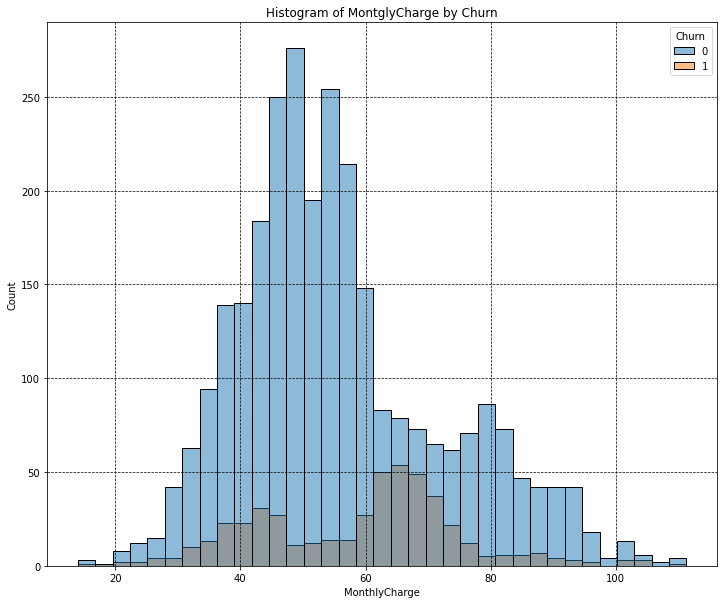

In [18]:
plt.title("Histogram of MontglyCharge by Churn")
sns.histplot(data = data, x = "MonthlyCharge", hue = "Churn");
plt.grid (color = 'black', linestyle = '--', linewidth = 0.7)

From the graph above we can conclude that customers that churn have bimodal distribution.

## 2.3 Correlation and Feature to Feature Relationship

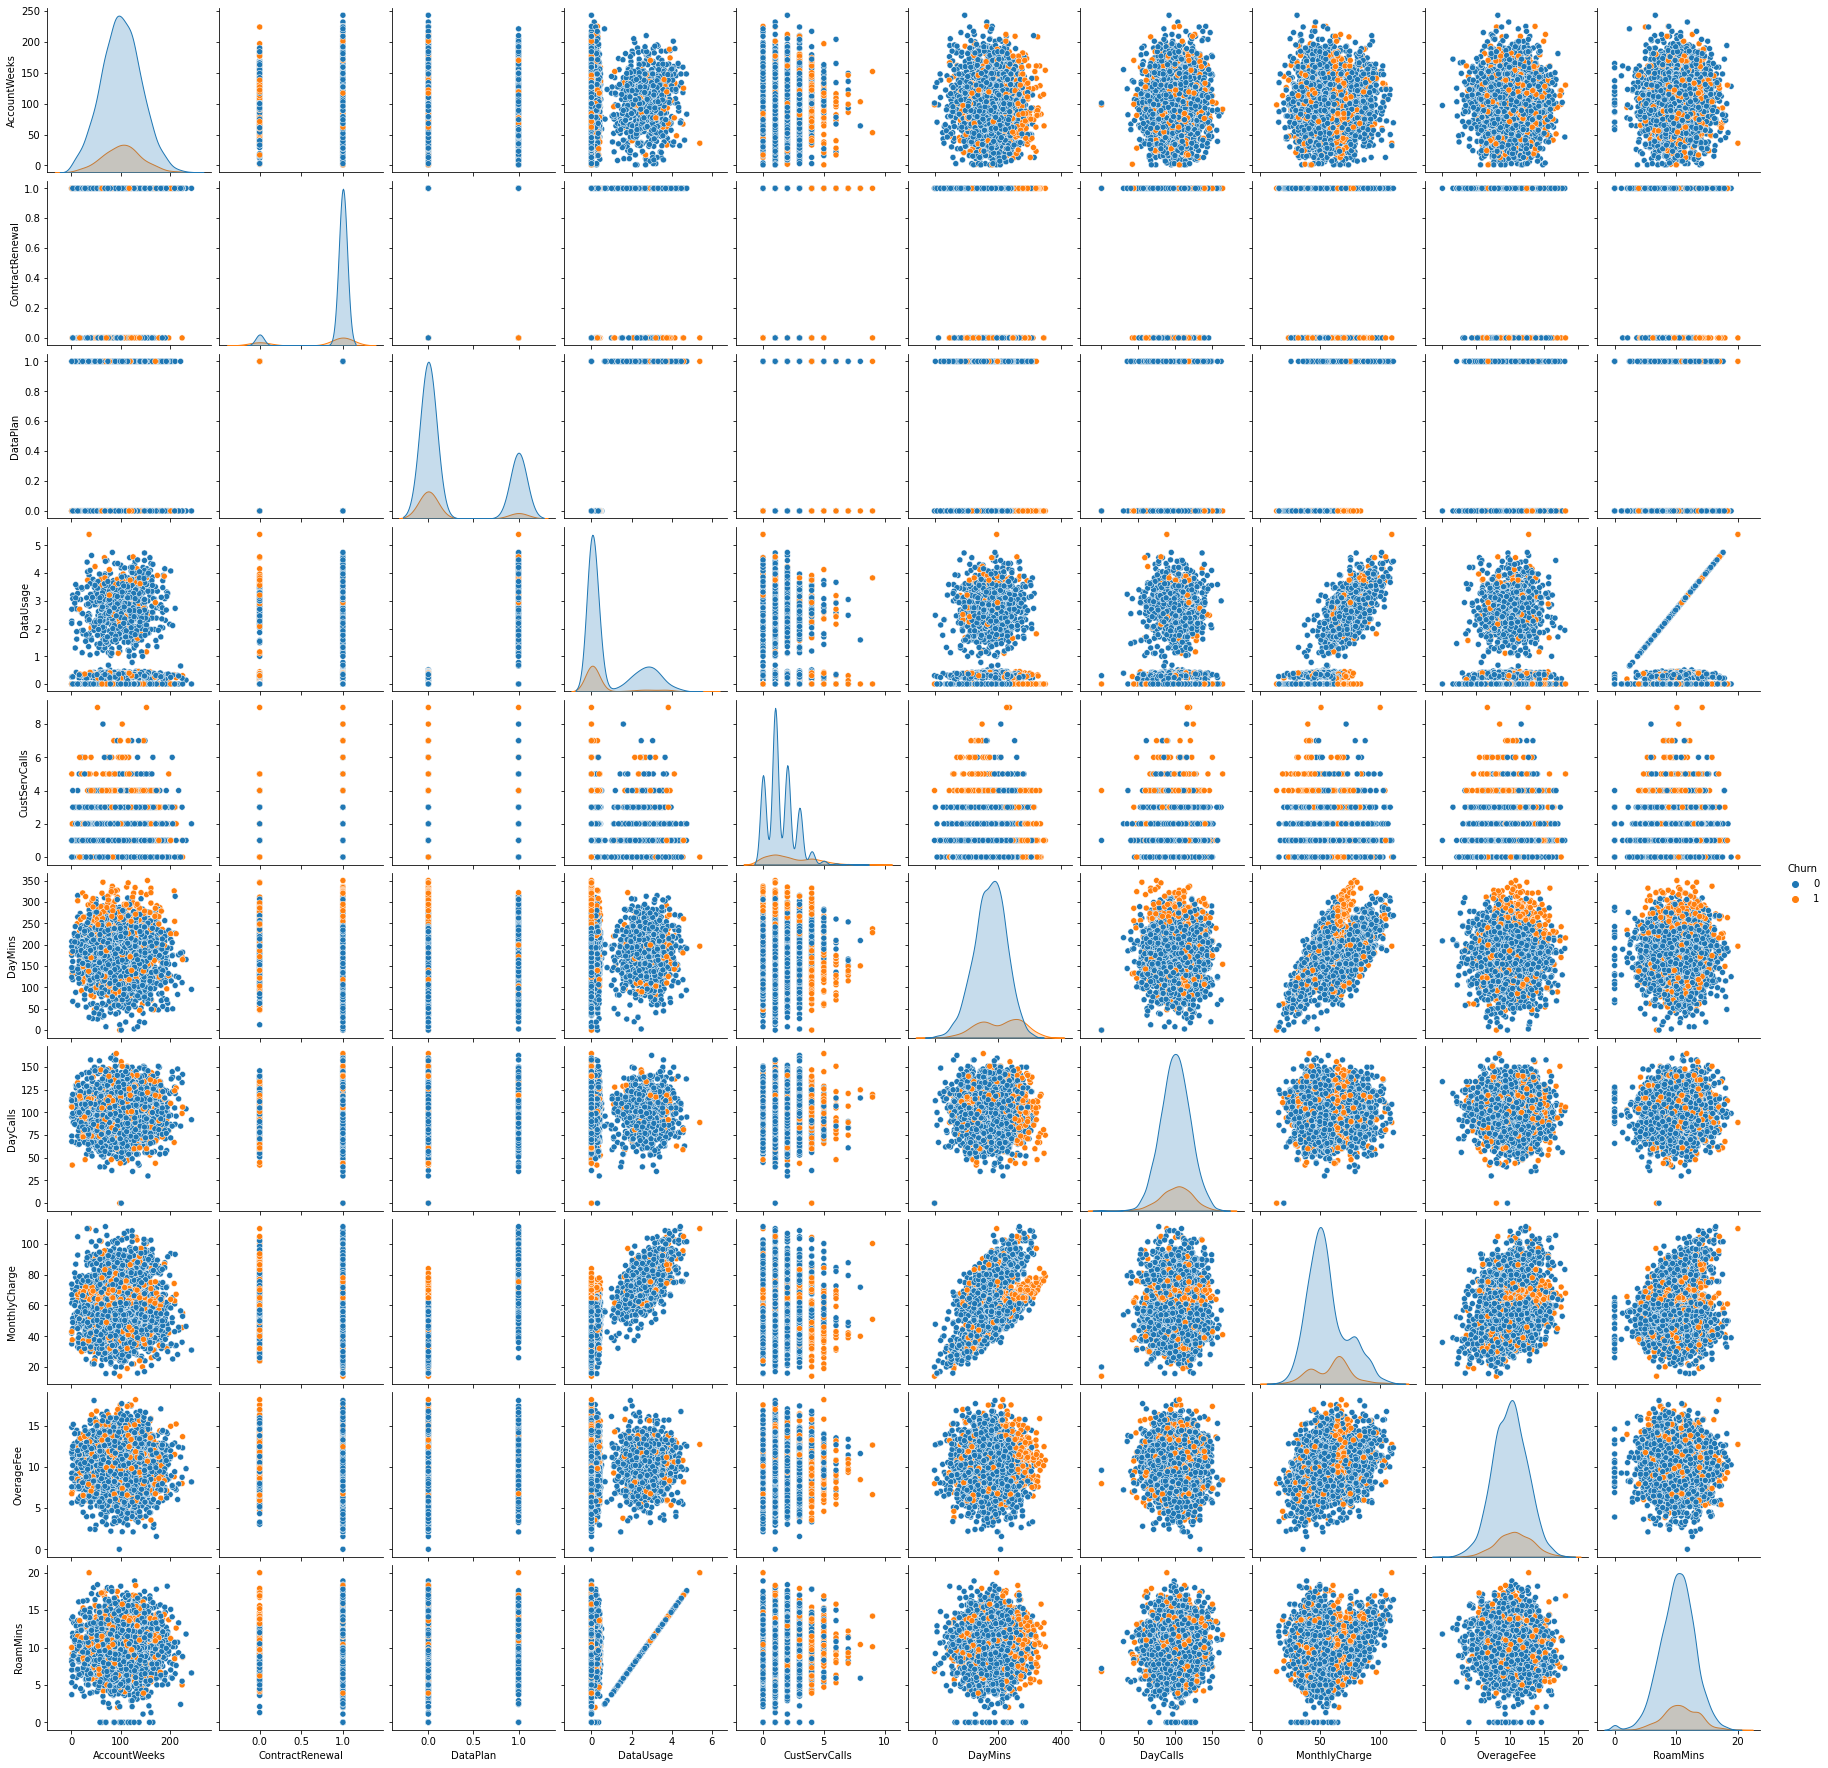

In [19]:
sns.pairplot(data, hue = "Churn");

From the graph we can conclude that  DayMins, RoamMins and OverageFee features are very important for classification. Because in this graphs we can see that customers that churn are more grouped.

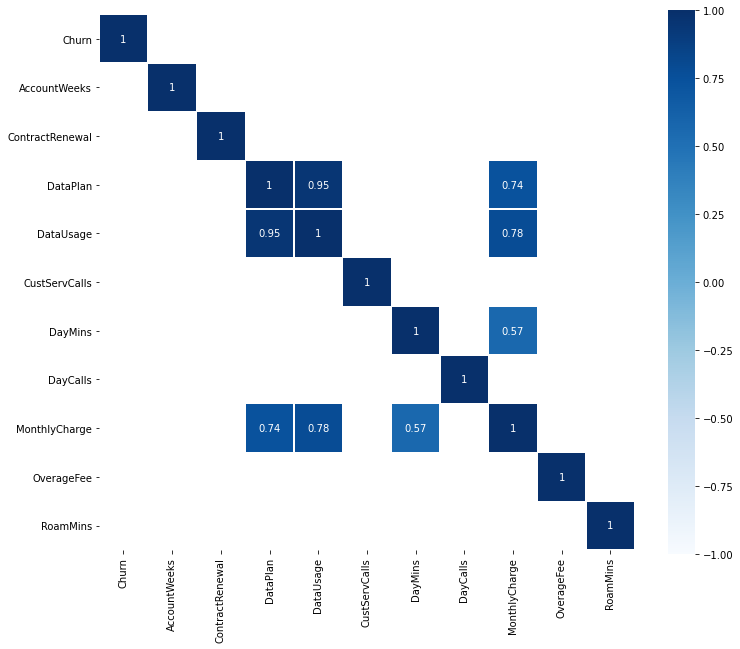

In [20]:
corr = data.corr() 
#plt.figure(figsize=(12, 12))

sns.heatmap(corr[(corr >= 0.3) | (corr <= -0.3)], 
            cmap='Blues', vmax=1.0, vmin=-1.0, linewidths=0.3,
            annot=True, annot_kws={"size": 10}, square=True);

#### MonthlyCharge relationship among {DataUsage, DayMins}

<Figure size 1440x1440 with 0 Axes>

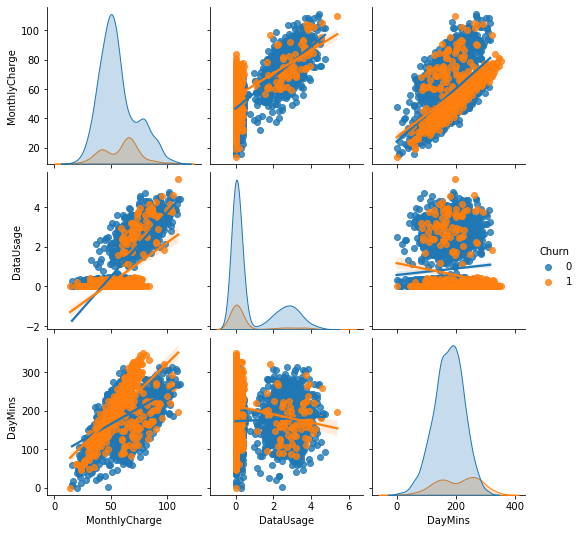

In [21]:
plt.figure(figsize=(20, 20))
sns.pairplot(vars=['MonthlyCharge', 'DataUsage', 'DayMins'],
           hue='Churn', data=data, kind='reg', diag_kind='kde');

plt.show()

#### DataUsage DataMins scatterplot-ից երևում է որ ըստ Target Churn դասի ռեգրեսիոն գծերը ունեն տարբեր ուղղություններ

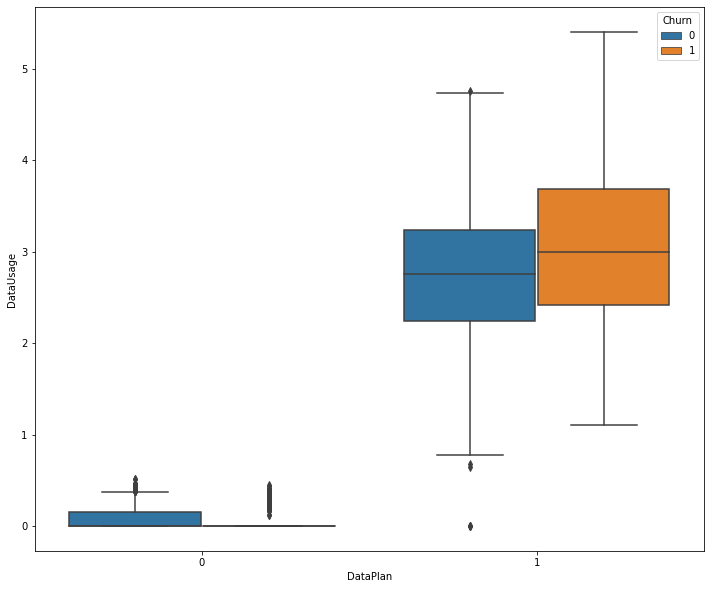

In [22]:
sns.boxplot(y='DataUsage', x='DataPlan', data=data, hue='Churn');

# 3. Implementing ML algorithms in Unbalanced Data

## 3.1 Implementing unpreprocessed data

In [11]:
X, y = data.iloc[:, 1:].values, data.Churn.values
x_train, x_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=0)
algorithms = [LogisticRegression(), 
             GaussianNB(),
             KNeighborsClassifier(),
             DecisionTreeClassifier(),
             RandomForestClassifier()]
accuracy = []
precision = []
recall = []
f1_scores = []
for algorithm in algorithms:
    algorithm.fit(x_train, y_train)
    y_pred = algorithm.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
summ = pd.DataFrame(data={'model':['LogR', 'NaiveB', 'KNN', 'DT', 'RandomF'],
                          'accuracy':accuracy, 'precision':precision,
                         'recall':recall, 'F1':f1_scores})
summ.sort_values('F1', ascending=False)

C:\Users\rafael_s\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model  accuracy  precision    recall        F1
4  RandomF  0.938531   0.797468  0.715909  0.754491
3       DT  0.884558   0.550459  0.681818  0.609137
1   NaiveB  0.844078   0.414894  0.443182  0.428571
2      KNN  0.868066   0.500000  0.261364  0.343284
0     LogR  0.859070   0.411765  0.159091  0.229508

##### for not normalized data the best performance had RandomForest

## 3.2 Implementing in Scaled Data

### 3.2.1. Standard Scaled Data, in this loop we will add SVM and QDA

In [12]:
X, y = data.iloc[:, 1:], data.Churn.values
X = (X - X.mean(axis=0)) / X.std(axis=0).values
x_train, x_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=0)
algorithms = [LogisticRegression(), 
             GaussianNB(),
             KNeighborsClassifier(),
             DecisionTreeClassifier(),
             RandomForestClassifier(),
             QuadraticDiscriminantAnalysis(),
             SVC()]
accuracy = []
precision = []
recall = []
f1_scores = []
for algorithm in algorithms:
    algorithm.fit(x_train, y_train)
    y_pred = algorithm.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
summ = pd.DataFrame(data={'model':['LogR', 'NaiveB', 'KNN', 'DT', 'RandomF', 'QDA', 'SVC'],
                          'accuracy':accuracy, 'precision':precision,
                         'recall':recall, 'F1':f1_scores})
summ.sort_values('F1', ascending=False)

model  accuracy  precision    recall        F1
4  RandomF  0.935532   0.784810  0.704545  0.742515
6      SVC  0.928036   0.844828  0.556818  0.671233
3       DT  0.881559   0.540541  0.681818  0.603015
2      KNN  0.914543   0.792453  0.477273  0.595745
5      QDA  0.857571   0.464646  0.522727  0.491979
1   NaiveB  0.844078   0.414894  0.443182  0.428571
0     LogR  0.872564   0.545455  0.204545  0.297521

##### In Standard Scaled Data Still the best performance based by F1 score is RandomForest, but we will keep SVC also(we can do hyperparameter tuning)

### 3.2.2. MinMax Scaled

In [13]:
X, y = data.iloc[:, 1:], data.Churn.values
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)).values
x_train, x_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=0)
algorithms = [LogisticRegression(), 
             GaussianNB(),
             KNeighborsClassifier(),
             DecisionTreeClassifier(),
             RandomForestClassifier(),
             QuadraticDiscriminantAnalysis(),
             SVC()]
accuracy = []
precision = []
recall = []
f1_scores = []
for algorithm in algorithms:
    algorithm.fit(x_train, y_train)
    y_pred = algorithm.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
summ = pd.DataFrame(data={'model':['LogR', 'NaiveB', 'KNN', 'DT', 'RandomF', 'QDA', 'SVC'],
                          'accuracy':accuracy, 'precision':precision,
                         'recall':recall, 'F1':f1_scores})
summ.sort_values('F1', ascending=False)

model  accuracy  precision    recall        F1
4  RandomF  0.940030   0.807692  0.715909  0.759036
3       DT  0.892054   0.576923  0.681818  0.625000
2      KNN  0.916042   0.775862  0.511364  0.616438
6      SVC  0.920540   0.948718  0.420455  0.582677
5      QDA  0.857571   0.464646  0.522727  0.491979
1   NaiveB  0.844078   0.414894  0.443182  0.428571
0     LogR  0.875562   0.600000  0.170455  0.265487

##### Still the RandomForest is the best, SVC performance is good but we can see that SVC is weak in recall, thats why we get lower F1 score

#### Usable Functions for visualizing confusion matrix heatmap, auc_roc curve
#### Also defining function which doing balanced train test split and function which simulates balancing algorithm in different combinations of hyperparameters then fits that data in given model and records F1 score

In [21]:
def confusion_matrix_heat(y_test, y_pred):
    data = np.vstack((y_test, y_pred)).T
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted']).round(decimals=0)
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                                   rownames=['Actual'], 
                                   colnames=['Predicted'])
    
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues',fmt='g')
    plt.text(0.95, 0.95, 'TN', ha='right', fontsize=14, weight='bold', color='green')
    plt.text(1.95, 0.95, 'TYPE 2 ERROR\n FP', ha='right', fontsize=12, weight='bold', color='red')
    plt.text(0.95, 1.95, 'TYPE 1 ERROR\n FN', ha='right', fontsize=12, weight='bold', color='red')
    plt.text(1.95, 1.95, 'TP', ha='right', fontsize=14, weight='bold', color='green')
    plt.xticks(np.arange(0.0, 1.01, 0.1))
    plt.yticks(np.arange(0.0, 1.01, 0.1))
    plt.show()
    
def auc_roc(y_test, y_pred):
    
    auc = roc_auc_score(y_test, y_pred)

    false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, y_pred)

    plt.figure(figsize=(10, 8), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'b')
    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightblue', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='black')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xticks(np.arange(0.0, 1.01, 0.1))
    plt.yticks(np.arange(0.0, 1.01, 0.1))
    plt.grid (color = 'black', linestyle = '--', linewidth = 0.7)
    plt.show()
    
def simulate(df, comb, algorithm, method, new_gen):
    start = datetime.datetime.now()
    accuracy, recall, precision, f1 = [], [], [], []
    for i in range(comb.shape[0]):
        try:
            model = SyMProD(nt=comb.iloc[i, 0], ct=comb.iloc[i, 1],
                       k=comb.iloc[i, 2], m=comb.iloc[i, 3])
            df_new = model.fit(df, method, new_gen)
            df_new = df_new.sample(frac=1.0).copy()
            x_train, x_test, y_train, y_test = balanced_tts(df_new, 0.2)
            algorithm.fit(x_train, y_train)
            y_pred = algorithm.predict(x_test)
            accuracy.append(accuracy_score(y_test, y_pred))
            recall.append(recall_score(y_test, y_pred))
            precision.append(precision_score(y_test, y_pred))
            f1.append(f1_score(y_test, y_pred))
        except:
            print(f"Fit method did not work for this parameters, {comb.iloc[i, 0], comb.iloc[i, 1], comb.iloc[i, 2], comb.iloc[i, 3]}")
    comb['Accuracy'] = np.array(accuracy)
    comb['Recall'] = np.array(recall)
    comb['Precision'] = np.array(precision)
    comb['F1'] = np.array(f1)
    print("Simulation take: ", str(datetime.datetime.now() - start))
    return comb.sort_values('F1', ascending=False)

def balanced_tts(df, test_size):
    df = df.values
    n_test = int(df.shape[0] * test_size)
    ind0 = np.where(df[:, -1] == 0)[0]
    ind1 = np.where(df[:, -1] == 1)[0]
    testind0 = np.random.choice(ind0, n_test//2, replace=False)
    testind1 = np.random.choice(ind1, n_test//2, replace=False)
    trainind0 = [ind0[i] for i in range(len(ind0)) if ind0[i] not in testind0]
    trainind1 = [ind1[i] for i in range(len(ind1)) if ind1[i] not in testind1]
    df_train0 = df[trainind0, :]
    df_test0 = df[testind0, :]
    df_train1 = df[trainind1, :]
    df_test1 = df[testind1, :]
    df_train = np.vstack((df_train0, df_train1))
    df_test = np.vstack((df_test0, df_test1))
    np.random.shuffle(df_train)
    np.random.shuffle(df_test)
    return df_train[:, :-1], df_test[:, :-1], df_train[:, -1], df_test[:, -1]

# 4. Implementing ML algorithms in Balanced Data 

## 4.1 Balancing Data

In [22]:
# target column has to be in the end when we implementing Oversampling algorthm
df = data[list(data.columns[1:]) + [data.columns[0]]].copy()

df1 = model.fit(df,  method='near_col', num_gen=7000)
print("Oversampling Model summary")
model.summary

Oversampling Model summary


{'Given data shape': (3333, 11),
 'Majority instance label and count': (0, 2850),
 'Minority instance label and count': (1, 483),
 'Number of new instances': 2367,
 'Time taken': '0:00:01.682740',
 'New data shape': (5700, 11)}

In [23]:
df1.head(15)

AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
4438      0.404535         0.825166  0.000000   0.005828       0.119472   
3114      0.206612         1.000000  0.000000   0.000000       0.250000   
398       0.607143         0.000000  0.000000   0.038889       0.000000   
5217      0.510205         0.744221  0.297075   0.159760       0.245344   
3445      0.400225         1.000000  0.000000   0.000000       0.235386   
4754      0.442565         1.000000  0.140106   0.084525       0.345413   
5207      0.324468         1.000000  0.470351   0.171182       0.366521   
2435      0.359504         0.000000  1.000000   0.738947       0.125000   
296       0.508929         0.000000  0.000000   0.000000       0.333333   
3419      0.444584         0.969803  0.000000   0.020132       0.593037   
4174      0.479556         1.000000  0.000000   0.002083       0.340565   
2396      0.561983         1.000000  1.000000   0.648421       0.250000   
4448      0.502613         0.720610  0.000000   0.000000       0.297553   
5095      0.433263         0.910086  0.000000   0.017373       0.207693   
2595      0.181818         1.000000  0.000000   0.000000       0.125000   

       DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  Churn  
4438  0.628140  0.441965       0.432958    0.448965  0.458524      1  
3114  0.571926  0.539877       0.285565    0.372582  0.529101      0  
398   0.735462  0.678788       0.553125    0.599727  0.494444      0  
5217  0.539358  0.597429       0.452336    0.413520  0.406484      1  
3445  0.456155  0.409171       0.335544    0.514855  0.384804      1  
4754  0.540241  0.669937       0.413371    0.412157  0.545687      1  
5207  0.507663  0.620625       0.405860    0.275240  0.440041      1  
2435  0.914132  0.699387       0.903766    0.562189  0.687831      0  
296   0.716363  0.418182       0.531250    0.620219  0.438889      0  
3419  0.270725  0.608564       0.187816    0.331740  0.493511      1  
4174  0.505473  0.723857       0.337458    0.397117  0.334470      1  
2396  0.600760  0.257669       0.660042    0.494748  0.603175      0  
4448  0.514176  0.686847       0.327151    0.334560  0.425824      1  
5095  0.566950  0.626875       0.444977    0.629432  0.191132      1  
2595  0.304499  0.631902       0.233264    0.682145  0.513228      1

### 4.1.1. Visualizations

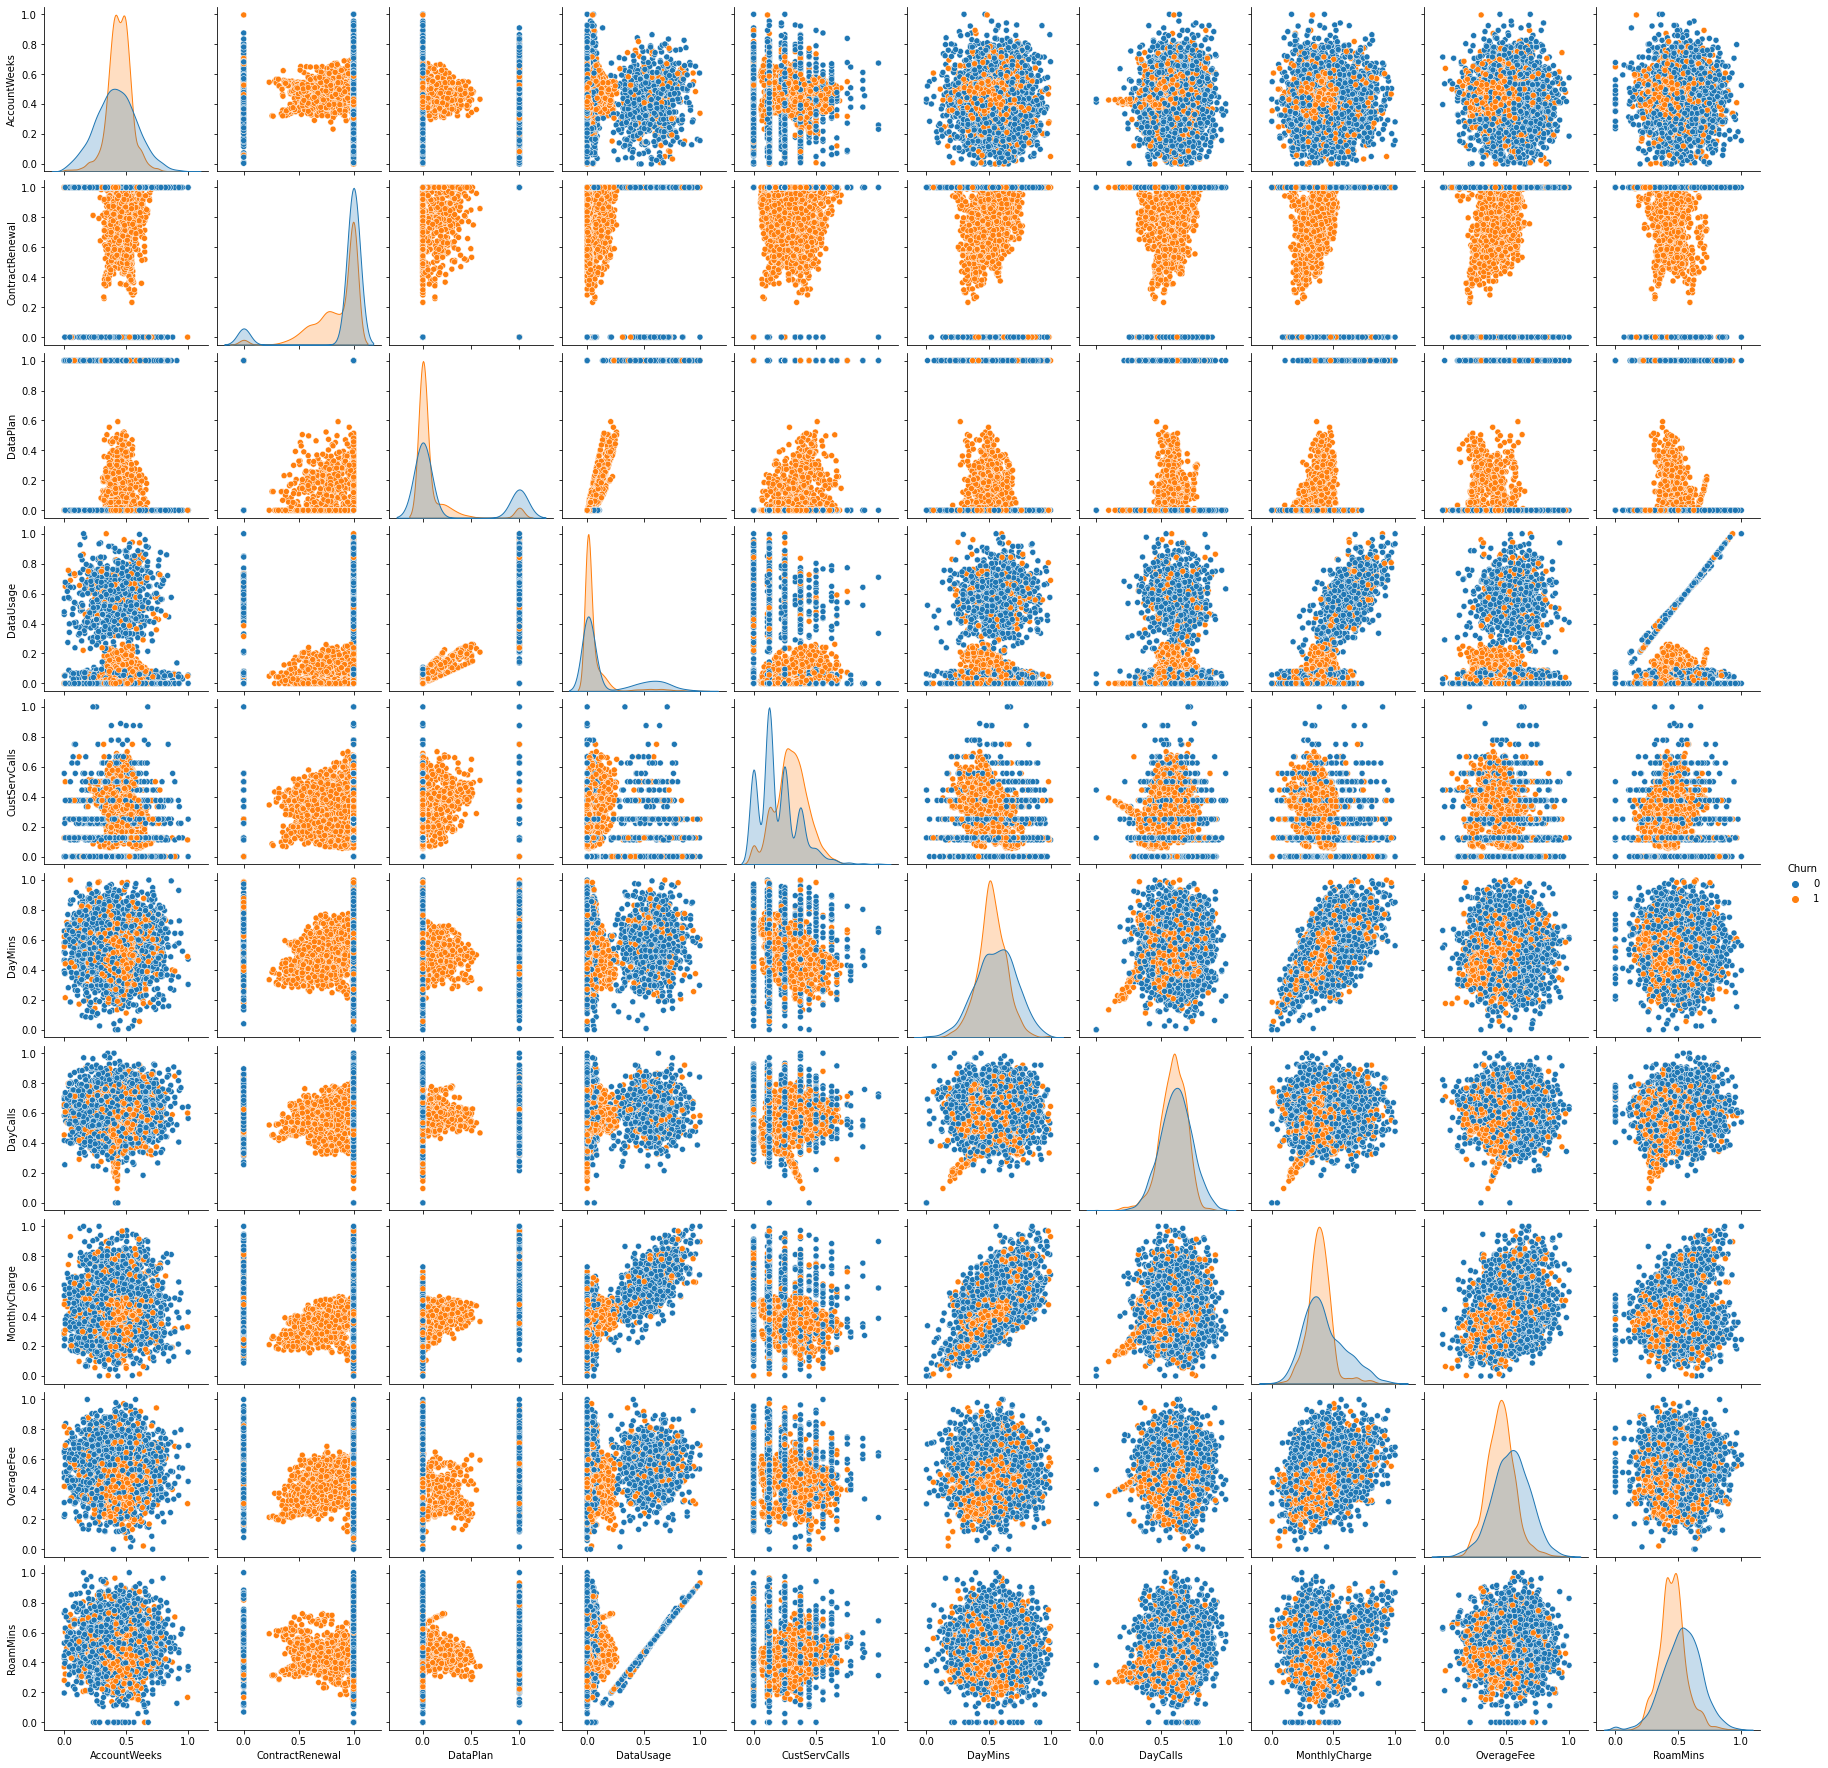

In [24]:
sns.pairplot(df1, kind='scatter', hue='Churn');

## 4.2.1. Algorithms implementing, firstly by sklearn train_test_split, then by our defined function

In [25]:
# Shuffling data
df = df1.sample(frac=1.0).copy() 

X, y = df.iloc[:, :-1].values, df.Churn.values
x_train, x_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=0)
algorithms = [LogisticRegression(), 
             GaussianNB(),
             KNeighborsClassifier(),
             DecisionTreeClassifier(),
             RandomForestClassifier(),
             QuadraticDiscriminantAnalysis(),
             SVC()]
accuracy = []
precision = []
recall = []
f1_scores = []
for algorithm in algorithms:
    algorithm.fit(x_train, y_train)
    y_pred = algorithm.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
summ = pd.DataFrame(data={'model':['LogR', 'NaiveB', 'KNN', 'DT', 'RandomF', 'QDA', 'SVC'],
                          'accuracy':accuracy, 'precision':precision,
                         'recall':recall, 'F1':f1_scores})
summ.sort_values('F1', ascending=False)

model  accuracy  precision    recall        F1
4  RandomF  0.909649   0.995575  0.816697  0.897308
2      KNN  0.891228   0.934827  0.833031  0.880998
6      SVC  0.892105   0.951477  0.818512  0.880000
5      QDA  0.864035   0.883721  0.827586  0.854733
0     LogR  0.843860   0.830088  0.851180  0.840502
3       DT  0.832456   0.810345  0.852995  0.831123
1   NaiveB  0.750877   0.690987  0.876588  0.772800

#### recall measure has increased for all models

## 4.2.2. Algorithms implementing, by spliting our data with our defined balanced train test split function 

In [26]:
x_train, x_test, y_train, y_test = balanced_tts(df1, 0.2)
algorithms = [LogisticRegression(), 
             GaussianNB(),
             KNeighborsClassifier(),
             DecisionTreeClassifier(),
             RandomForestClassifier(),
             QuadraticDiscriminantAnalysis(),
             SVC()]
accuracy = []
precision = []
recall = []
f1_scores = []
for algorithm in algorithms:
    algorithm.fit(x_train, y_train)
    y_pred = algorithm.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
summ = pd.DataFrame(data={'model':['LogR', 'NaiveB', 'KNN', 'DT', 'RandomF', 'QDA', 'SVC'],
                          'accuracy':accuracy, 'precision':precision,
                         'recall':recall, 'F1':f1_scores})
summ.sort_values('F1', ascending=False)

model  accuracy  precision    recall        F1
4  RandomF  0.921053   0.997925  0.843860  0.914449
6      SVC  0.899123   0.948718  0.843860  0.893222
2      KNN  0.878947   0.904494  0.847368  0.875000
5      QDA  0.872807   0.888483  0.852632  0.870188
0     LogR  0.842982   0.827471  0.866667  0.846615
3       DT  0.841228   0.829103  0.859649  0.844100
1   NaiveB  0.739474   0.682243  0.896491  0.774829

#### We will take RandomForest, SVC, KNN for hyperparameters tuning

## 4.3. Hyperparameter tuning for given best models

### 4.3.1. SVC
##### with different parameters

In [27]:
start = datetime.datetime.now()

param_grid = {'C': [0.1, 10, 20], 
              'gamma': [1, 0.1, 0.05],
              'kernel': ['rbf', 'sigmoid', 'poly'],
              'degree': [1, 2, 3]
             } 
  
grid = GridSearchCV(SVC(), param_grid, refit = True)
grid.fit(x_train, y_train)

print("Best Parameters")
print(grid.best_params_)
print()  
print(grid.best_score_)
print('Time taken', datetime.datetime.now() - start, sep='\n')

Best Parameters
{'C': 20, 'degree': 1, 'gamma': 1, 'kernel': 'rbf'}

0.8975877192982458
Time taken
0:03:30.880593


#### After grid search implementing best estimators in both training and test datasets, for getting final scores and check whether the ML algorithm is Overfitted

Results in Training set
Accuracy score   0.9017543859649123
Recall score   0.8355263157894737
Precision score   0.9630940343781598
F1 score   0.8947862846406763

Results in Testing set
Accuracy score   0.8982456140350877
Recall score   0.8456140350877193
Precision score   0.9450980392156862
F1 score   0.8925925925925925


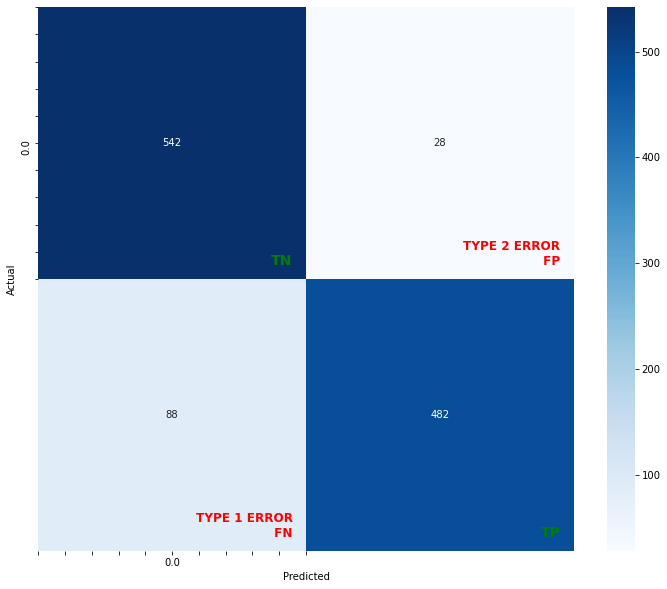

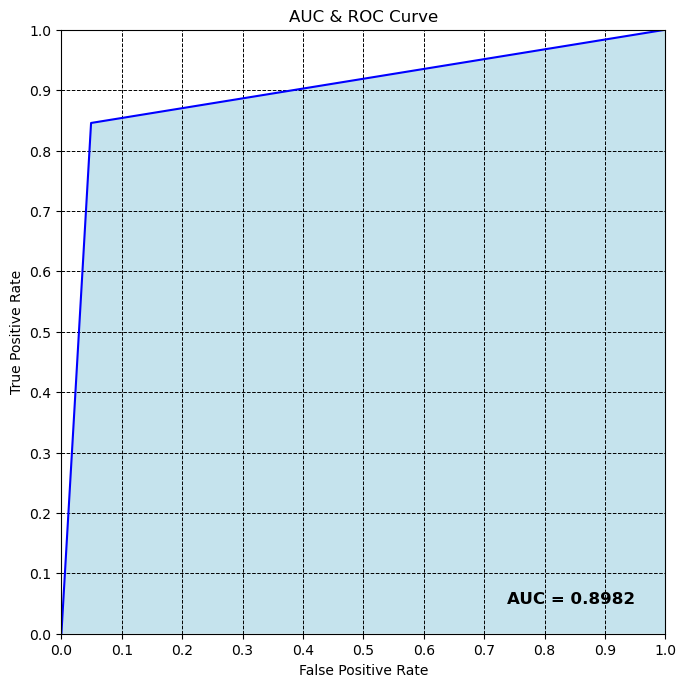

In [28]:
svm = SVC(C=20, gamma=1, kernel='rbf')
svm.fit(x_train, y_train)
y_pred_train = svm.predict(x_train)
y_pred_test = svm.predict(x_test)
print("Results in Training set")
print('Accuracy score  ', accuracy_score(y_train, y_pred_train))
print('Recall score  ', recall_score(y_train, y_pred_train))
print('Precision score  ', precision_score(y_train, y_pred_train))
print('F1 score  ', f1_score(y_train, y_pred_train))
print()
print("Results in Testing set")
print('Accuracy score  ', accuracy_score(y_test, y_pred_test))
print('Recall score  ', recall_score(y_test, y_pred_test))
print('Precision score  ', precision_score(y_test, y_pred_test))
print('F1 score  ', f1_score(y_test, y_pred_test))
confusion_matrix_heat(y_test, y_pred_test)
auc_roc(y_test, y_pred_test)

##### No overfitting problem

### 4.3.2. Random Forest Classifier
#### with different parameters

In [29]:
start = datetime.datetime.now()

params = {'n_estimators': [20, 50, 100, 200], 
              'criterion': ['gini', 'entropy'],
              'max_depth': [None, 3, 5]} 
  
grid = GridSearchCV(RandomForestClassifier(), params, refit=True)
grid.fit(x_train, y_train)

print("Best Parameters")
print(grid.best_params_)
print()  
print(grid.best_score_)
print()
print('Time taken', datetime.datetime.now() - start, sep='\n')

Best Parameters
{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}

0.9096491228070175

Time taken
0:01:30.221090


#### the best are the default parameters, again we will implement the best estimator in both training and test sets to find the scores and check Overfitting problem 

Results in Training set
Accuracy score   1.0
Recall score   1.0
Precision score   1.0
F1 score   1.0

Results in Testing set
Accuracy score   0.9210526315789473
Recall score   0.843859649122807
Precision score   0.9979253112033195
F1 score   0.9144486692015209


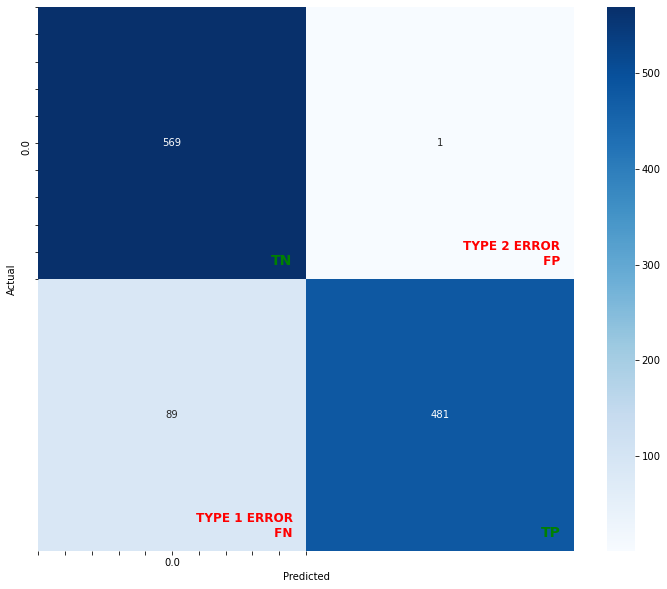

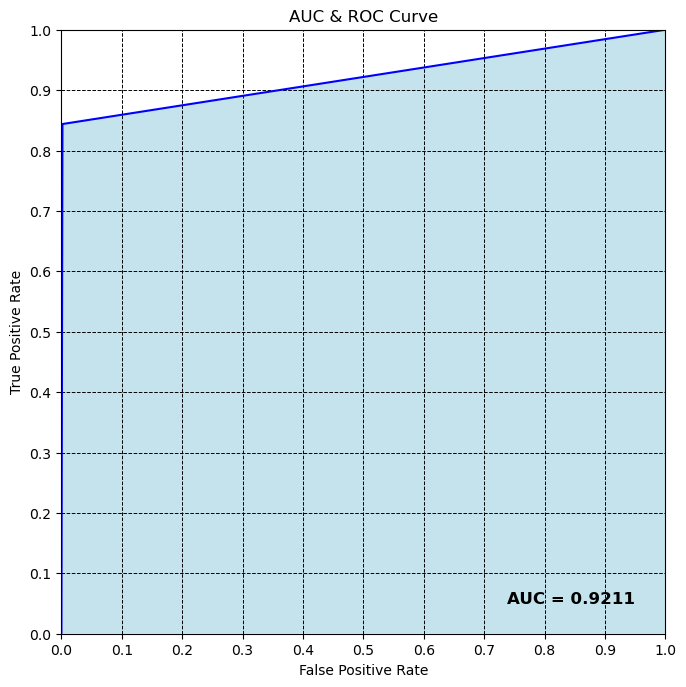

In [30]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(x_train, y_train)
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)
print("Results in Training set")
print('Accuracy score  ', accuracy_score(y_train, y_pred_train))
print('Recall score  ', recall_score(y_train, y_pred_train))
print('Precision score  ', precision_score(y_train, y_pred_train))
print('F1 score  ', f1_score(y_train, y_pred_train))
print()
print("Results in Testing set")
print('Accuracy score  ', accuracy_score(y_test, y_pred_test))
print('Recall score  ', recall_score(y_test, y_pred_test))
print('Precision score  ', precision_score(y_test, y_pred_test))
print('F1 score  ', f1_score(y_test, y_pred_test))
confusion_matrix_heat(y_test, y_pred_test)
auc_roc(y_test, y_pred_test)

#### In RandomForest we have obvious Overfitting problem

### 4.3.3. KNN
#### with different parameters

In [31]:
start = datetime.datetime.now()

params = {'n_neighbors': [5, 7, 3], 'p': [2, 3, 4], 
          'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'euclidean']} 
  
grid = GridSearchCV(KNeighborsClassifier(), params, refit=True, 
                    return_train_score=True, scoring = 'accuracy')
grid.fit(x_train, y_train)

print("Best Parameters")
print(grid.best_params_)
print()  
print(grid.best_score_)
print()
print('Time taken', datetime.datetime.now() - start, sep='\n')

Best Parameters
{'metric': 'minkowski', 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}

0.8745614035087718

Time taken
0:02:45.113676


Results in Training set
Accuracy score   1.0
Recall score   1.0
Precision score   1.0
F1 score   1.0

Results in Testing set
Accuracy score   0.8885964912280702
Recall score   0.856140350877193
Precision score   0.9155722326454033
F1 score   0.884859474161378


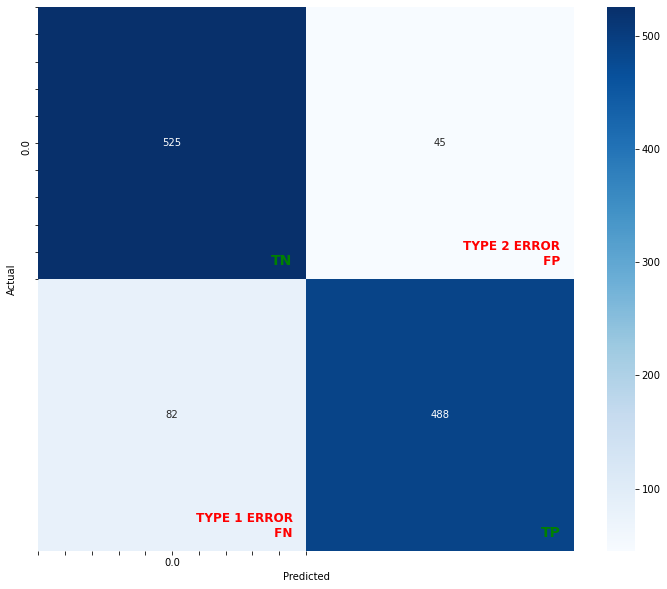

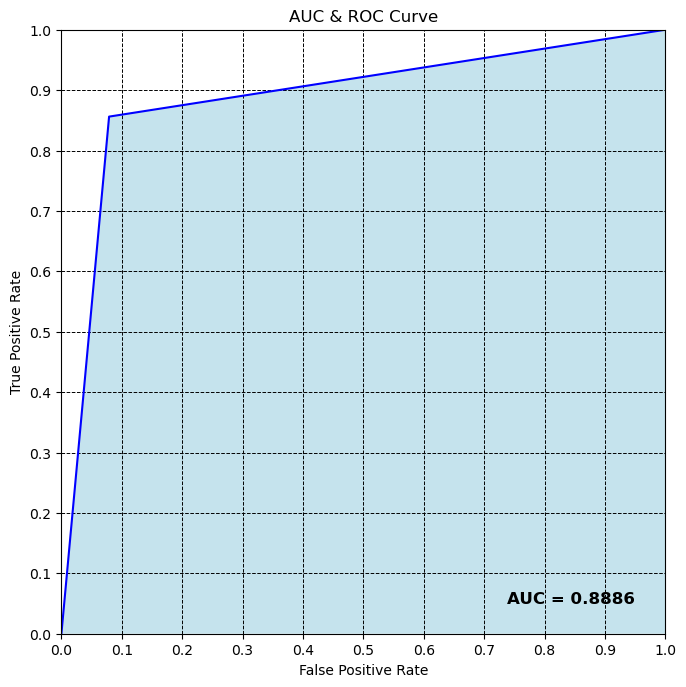

In [32]:
knn = KNeighborsClassifier(n_neighbors=7,
                                p=2, weights='distance', metric='minkowski')
knn.fit(x_train, y_train)
y_pred_train = knn.predict(x_train)
y_pred_test = knn.predict(x_test)
print("Results in Training set")
print('Accuracy score  ', accuracy_score(y_train, y_pred_train))
print('Recall score  ', recall_score(y_train, y_pred_train))
print('Precision score  ', precision_score(y_train, y_pred_train))
print('F1 score  ', f1_score(y_train, y_pred_train))
print()
print("Results in Testing set")
print('Accuracy score  ', accuracy_score(y_test, y_pred_test))
print('Recall score  ', recall_score(y_test, y_pred_test))
print('Precision score  ', precision_score(y_test, y_pred_test))
print('F1 score  ', f1_score(y_test, y_pred_test))
confusion_matrix_heat(y_test, y_pred_test)
auc_roc(y_test, y_pred_test)

#### Obvious Overfitting problem

# 5. Hyperparameter tuning in Balancing Algorithm
#### Besides tuning hyperparameters of ML models we also can tune parameters of Oversampling algorithm, in this section we will try to Oversample our initial data by given different hyperparameters, then implement each data by given model and record results

### 5.1. Combinations of all hyperparameters of balancing algorithm
#### In this __[paper](https://sci-hub.do/10.1109/ACCESS.2020.3003346)__ it is suggested, that the optimal hyperparameters ranges are.
#####    * 1. Noise Threshold  - [3.0 - 5.0]
#####    * 2. Cutoff Threshold - [0.8 - 1.2]
#####    * 3. K                - [5 - 7]
#####    * 4. M                - [3 - 5]
#### Due to computational restriction we will try only a few combinations

In [33]:
nt = [2.5, 3.0, 4.0]
ct = [0.8, 1.0, 1.2]
k = [5, 7, 8]
m = [3, 5]
comb = pd.DataFrame(itertools.product(nt, ct, k, m))
comb.columns = ['NoiseT', 'CutoffT', 'K', 'M']
print(comb.shape)
comb.sample(frac=0.25)

(54, 4)


NoiseT  CutoffT  K  M
50     4.0      1.2  7  3
9      2.5      1.0  7  5
22     3.0      0.8  8  3
40     4.0      0.8  8  3
30     3.0      1.2  5  3
48     4.0      1.2  5  3
34     3.0      1.2  8  3
8      2.5      1.0  7  3
0      2.5      0.8  5  3
29     3.0      1.0  8  5
17     2.5      1.2  8  5
39     4.0      0.8  7  5
26     3.0      1.0  7  3
12     2.5      1.2  5  3

## 5.2 Simulating by given data, balancing algorithm parameters and by given ml classifier

#### Random Forest

In [34]:
df2 = data[list(data.columns[1:]) + [data.columns[0]]].copy()
simulate(df=df2, comb=comb, algorithm=rf, method='near_col', new_gen=6000).head(7)

Simulation take:  0:02:36.549053


NoiseT  CutoffT  K  M  Accuracy    Recall  Precision        F1
19     3.0      0.8  5  5  0.926316  0.854386   0.997951  0.920605
30     3.0      1.2  5  3  0.924561  0.856140   0.991870  0.919021
29     3.0      1.0  8  5  0.924561  0.856140   0.991870  0.919021
47     4.0      1.0  8  5  0.924561  0.849123   1.000000  0.918406
7      2.5      1.0  5  5  0.921930  0.847368   0.995876  0.915640
11     2.5      1.0  8  5  0.921053  0.845614   0.995868  0.914611
33     3.0      1.2  7  5  0.920175  0.843860   0.995859  0.913580

#### SVM

In [35]:
df2 = data[list(data.columns[1:]) + [data.columns[0]]].copy()
simulate(df=df2, comb=comb, algorithm=svm, method='near_col', new_gen=6000).head(7)

Simulation take:  0:02:06.082131


NoiseT  CutoffT  K  M  Accuracy    Recall  Precision        F1
50     4.0      1.2  7  3  0.931579  0.863158   1.000000  0.926554
31     3.0      1.2  5  5  0.925439  0.868421   0.980198  0.920930
25     3.0      1.0  5  5  0.921053  0.842105   1.000000  0.914286
23     3.0      0.8  8  5  0.917544  0.857895   0.974104  0.912313
45     4.0      1.0  7  5  0.917544  0.854386   0.977912  0.911985
42     4.0      1.0  5  3  0.918421  0.836842   1.000000  0.911175
34     3.0      1.2  8  3  0.916667  0.845614   0.985685  0.910293

#### KNN

In [36]:
df2 = data[list(data.columns[1:]) + [data.columns[0]]].copy()
simulate(df=df2, comb=comb, algorithm=knn, method='near_col', new_gen=6000).head(7)

Simulation take:  0:01:17.161558


NoiseT  CutoffT  K  M  Accuracy    Recall  Precision        F1
51     4.0      1.2  7  5  0.920175  0.850877   0.987780  0.914232
17     2.5      1.2  8  5  0.914912  0.854386   0.972056  0.909430
33     3.0      1.2  7  5  0.914035  0.838596   0.987603  0.907021
25     3.0      1.0  5  5  0.912281  0.845614   0.975709  0.906015
35     3.0      1.2  8  5  0.912281  0.838596   0.983539  0.905303
43     4.0      1.0  5  5  0.911404  0.842105   0.977597  0.904807
49     4.0      1.2  5  5  0.909649  0.849123   0.966068  0.903828

# Conclusion
## By comparing Results

#### Comparing results, 
#### The best accuracy and f1 score we get from RandomForestClassifier : {94%, 76%}; in Unbalanced Data 
#### The best accuracy and f1 score we get from RandomForestClassifier : {92%, 92%}; in Balanced Data.
#### But in visualization we can see that categorical features is not generated properly, maybe this needs to add logic in algorithm that will keep track with categorical columns and generate new values in different, because in majority cases categorical features do not have outliers, or we just can round that values. (e.g. for column which has only 0 and 1 values, if newly generated value is 0.87 we can round it as 1). Plus it can be useful to target Recall value increasing. 